# Kickstarter Projects
# Day 2 Homework for a Machine Learning Course
Author：Hiroki Miyamoto

# Links to my homeworks
- Kaggle
    - Day1
        - Objective of Day 1 : Build a supervised machine learning model based on the lecture on Day 1. Don't care about the accuracy for now.¶
        - https://www.kaggle.com/hmiyamoto/day-1-homework-for-a-machine-learning-course/
- GitHub
    - https://github.com/hmiyamoto1/skillupai_ml

## Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.

### Table of Contents (Day 2)
1. Check the generalization performance using a hold-out method or cross-validation
1. Apply regularization
1. Apply normalization
1. Apply decorrelation
1. Apply SVM

# 1. Check the generalization performance using a hold-out method or cross-validation
- Model
    - The same model as Day 1
        - Linear regression
        - No regularization
    - **Cross validation (Train:80%/Test:20% - 5 times) is applied here.**
- Result
    - Before cross validation (All data is used as train/test data. Generalization was not considered on Day 1.)
        - Log-likelihood = -0.178
        - Accuracy = 99.485%
    - **After cross validation**
        - **Cross Validation Log-likelihood = -0.274**
        - **Cross Validation Accuracy = 99.208%**
            - **Generalization performance is not as good as the performance during the training phase.**

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Acquire data

In [2]:
df_kick = pd.read_csv("../input/ks-projects-201801.csv")

## Preview the data

In [3]:
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Create dataframe with selected features

- Objective variable
    - state_dummy (successful = 1, other = 0)
- Explanatory variables
    - backers_log10
    - usd_pledged_real_log10
    - usd_goal_real_log10
    - category_dummy
    - currency_dummy
    - time_campaign_dummy

In [4]:
df_kick['launched'] = pd.to_datetime(df_kick['launched'])
df_kick['laun_month_year'] = df_kick['launched'].dt.to_period("M")
df_kick['laun_year'] = df_kick['launched'].dt.to_period("A")
df_kick['laun_hour'] = df_kick['launched'].dt.hour

df_kick['deadline'] = pd.to_datetime(df_kick['deadline'])
df_kick['dead_month_year'] = df_kick['deadline'].dt.to_period("M")
df_kick['dead_year'] = df_kick['launched'].dt.to_period("A")

#Creating a new columns with Campaign total months
df_kick['time_campaign'] = df_kick['dead_month_year'] - df_kick['laun_month_year']
df_kick['time_campaign'] = df_kick['time_campaign'].astype(int)

df_kick['time_campaign_dummy'] = df_kick['time_campaign']
df_kick['time_campaign_dummy'].loc[df_kick['time_campaign_dummy'] >= 5] = 5

display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,laun_month_year,laun_year,laun_hour,dead_month_year,dead_year,time_campaign,time_campaign_dummy
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,0.0,1533.95,2015-08,2015,12,2015-10,2015,2,2
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,100.0,2421.0,30000.00,2017-09,2017,4,2017-11,2017,2,2
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,220.0,45000.00,2013-01,2013,0,2013-02,2013,1,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,1.0,5000.00,2012-03,2012,3,2012-04,2012,1,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,1283.0,1283.0,19500.00,2015-07,2015,8,2015-08,2015,1,1


In [5]:
df_kick['state_dummy'] = df_kick['state']
df_kick['state_dummy'].loc[df_kick['state_dummy'] != 'successful'] = 0
df_kick['state_dummy'].loc[df_kick['state_dummy'] == 'successful'] = 1

# display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# epsilon = 1e-8
epsilon = 1

df_kick['backers_log10'] = np.log10(df_kick['backers'] + epsilon)
df_kick['usd_pledged_real_log10'] = np.log10(df_kick['usd_pledged_real'] + epsilon)
df_kick['usd_goal_real_log10'] = np.log10(df_kick['usd_goal_real'] + epsilon)

display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,laun_year,laun_hour,dead_month_year,dead_year,time_campaign,time_campaign_dummy,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,2015,12,2015-10,2015,2,2,0,0.000000,0.000000,3.186094
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,2017,4,2017-11,2017,2,2,0,1.204120,3.384174,4.477136
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,2013,0,2013-02,2013,1,1,0,0.602060,2.344392,4.653222
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,2012,3,2012-04,2012,1,1,0,0.301030,0.301030,3.699057
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,2015,8,2015-08,2015,1,1,0,1.176091,3.108565,4.290057


In [7]:
y = df_kick["state_dummy"].values
X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data
    
#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])
    
    df_X_test = pd.DataFrame(X_test,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])
    



    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)
    
    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 
    
    
#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())
    

    print("Fold %s"%split_num)
    
    X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    
    clf = SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
    w3 = clf.coef_[0, 2]
    w4 = clf.coef_[0, 3]
    w5 = clf.coef_[0, 4]
    w6 = clf.coef_[0, 5]
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

    # Predict labels
    y_est_test = clf.predict(X_test)
    
    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()
    
#     cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# Generalization performance
final_log_likelihood_0 = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood_0, 3))
final_accuracy_0 = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy_0))

Fold 1
w0 = 0.685, w1 = 5.622, w2 = 157.838, w3 = -160.935, w4 = 2.587, w5 = 8.184, w6 = -0.166
Log-likelihood = -0.299
Accuracy = 99.135%

Fold 2
w0 = 0.602, w1 = 5.122, w2 = 129.931, w3 = -132.742, w4 = 2.488, w5 = 7.807, w6 = -0.092
Log-likelihood = -0.268
Accuracy = 99.225%

Fold 3
w0 = 1.107, w1 = 4.768, w2 = 121.272, w3 = -123.832, w4 = 2.446, w5 = 5.863, w6 = -0.204
Log-likelihood = -0.261
Accuracy = 99.245%

Fold 4
w0 = 1.048, w1 = 4.766, w2 = 120.677, w3 = -123.191, w4 = 2.541, w5 = 5.630, w6 = -0.175
Log-likelihood = -0.254
Accuracy = 99.266%

Fold 5
w0 = 1.396, w1 = 5.458, w2 = 143.022, w3 = -145.937, w4 = 2.900, w5 = 5.170, w6 = -0.138
Log-likelihood = -0.287
Accuracy = 99.168%

Cross Validation Log-likelihood = -0.274
Cross Validation Accuracy = 99.208%


# 2. Apply regularization

## Ridge (L2)
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - **L2 regularization is applied here.**
- Result
    - Before regularization
        - Cross Validation Log-likelihood = -0.274
        - Cross Validation Accuracy = 99.208%
    - **After regularization**
        - **alpha = 1e-6 is the best perfoemance. (1e-8 <= alpha <= 1e-1)**
        - **Cross Validation Log-likelihood = -0.345**
        - **Cross Validation Accuracy = 99.000%**
            - **L2 regularization didn't contribute to the performance improvement in this case.**

In [8]:
penalty = 'l2'

alphas_multiply = np.array(range(-8,0))
alphas = 10.0 ** alphas_multiply
# alpha = 0.0

L2_accuracy = []
L2_log_likelihood = []
L2_weight_abs_max = []
L2_weight_abs_min = []


for alpha in alphas:
    
    print('='*100)
    print('penalty =', penalty)
    print('alpha =', alpha)
    print()

    y = df_kick["state_dummy"].values
    X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Cross Validation
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] # Train data
        X_test, y_test = X[test_idx], y[test_idx]     # Test data

    #     print(X_train.shape)
    #     print(X_test.shape)
        df_X_train = pd.DataFrame(X_train,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_test = pd.DataFrame(X_test,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_test = pd.DataFrame(y_test,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

        # Create dummy variables for currency using train data
        # Replace currency to currency_success_rate
        currency_success_rate = {}
        df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
        df_currency_all_count = df_X_train['currency'].value_counts()
        for currency in df_currency_all_count.keys():
            currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
        df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
        df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


    #     display(df_X_train.head())
    #     display(df_y_train.head())

    #     display(df_X_test.head())
    #     display(df_y_test.head())


        print("Fold %s"%split_num)

        X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
        X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

        clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # Weight
        w0 = clf.intercept_[0]
        w1 = clf.coef_[0, 0]
        w2 = clf.coef_[0, 1]
        w3 = clf.coef_[0, 2]
        w4 = clf.coef_[0, 3]
        w5 = clf.coef_[0, 4]
        w6 = clf.coef_[0, 5]
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


        # Predict labels
        y_est_test = clf.predict(X_test)

        # Log-likelihood
        log_likelihood = - log_loss(y_test, y_est_test)    
        cross_valid_log_likelihood += log_likelihood    
        print('Log-likelihood = {:.3f}'.format(log_likelihood))

        # Accuracy
        accuracy = accuracy_score(y_test, y_est_test)
        cross_valid_accuracy += accuracy   
        print('Accuracy = {:.3f}%'.format(100 * accuracy))
        print()

    #     cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

    # Generalization performance
    final_log_likelihood = cross_valid_log_likelihood / n_split
    print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = cross_valid_accuracy / n_split
    print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    L2_accuracy.append(final_accuracy)
    L2_log_likelihood.append(final_log_likelihood)
    L2_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    L2_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

penalty = l2
alpha = 1e-08

Fold 1
w0 = -28.676, w1 = 53.044, w2 = 302.355, w3 = -329.078, w4 = 36.346, w5 = 96.580, w6 = 10.126
Log-likelihood = -0.436
Accuracy = 98.736%

Fold 2
w0 = -15.814, w1 = 38.536, w2 = 335.353, w3 = -353.983, w4 = 40.923, w5 = 95.831, w6 = -7.755
Log-likelihood = -0.322
Accuracy = 99.068%

Fold 3
w0 = -15.242, w1 = 30.939, w2 = 332.062, w3 = -342.305, w4 = 42.374, w5 = 97.126, w6 = -0.169
Log-likelihood = -0.478
Accuracy = 98.616%

Fold 4
w0 = -4.284, w1 = 28.707, w2 = 328.770, w3 = -340.410, w4 = 45.866, w5 = 92.862, w6 = -8.487
Log-likelihood = -0.420
Accuracy = 98.785%

Fold 5
w0 = -18.121, w1 = 33.251, w2 = 322.606, w3 = -330.069, w4 = 44.341, w5 = 94.472, w6 = -4.741
Log-likelihood = -0.565
Accuracy = 98.364%

Cross Validation Log-likelihood = -0.444
Cross Validation Accuracy = 98.714%
penalty = l2
alpha = 1e-07

Fold 1
w0 = -2.008, w1 = 4.946, w2 = 29.091, w3 = -31.123, w4 = 3.757, w5 = 10.261, w6 = 1.012
Log-likelihood = -0.472
Accuracy = 98.635%

Fold

Text(0,0.5,'Accuracy')

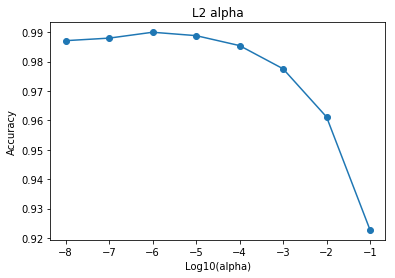

In [9]:
plt.plot(alphas_multiply, L2_accuracy, marker='o')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Accuracy")

Text(0,0.5,'Log-likelihood')

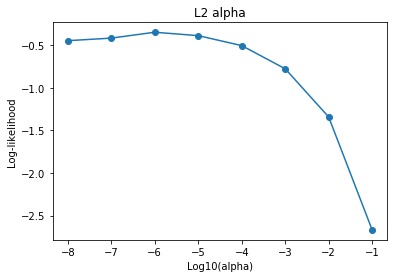

In [10]:
plt.plot(alphas_multiply, L2_log_likelihood, marker='o')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Log-likelihood")

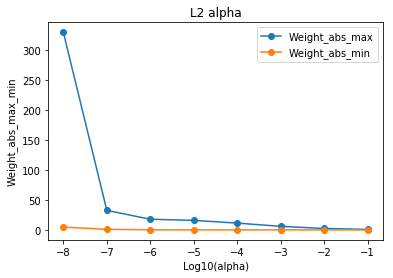

In [11]:
plt.plot(alphas_multiply, L2_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(alphas_multiply, L2_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Weight_abs_max_min")
plt.legend()

## Lasso (L1)
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - **L1 regularization is applied here.**
- Result
    - Before regularization
        - Cross Validation Log-likelihood = -0.274
        - Cross Validation Accuracy = 99.208%
    - **After regularization**
        - **alpha = 1e-4 is the best perfoemance. (1e-8 <= alpha <= 1e-1)**
        - **Cross Validation Log-likelihood = -0.26**
        - **Cross Validation Accuracy = 99.247%**
            - **L1 regularization contributed to the performance improvement in this case.**

In [12]:
penalty = 'l1'

alphas_multiply = np.array(range(-8,0))
alphas = 10.0 ** alphas_multiply
# alpha = 0.0

L1_accuracy = []
L1_log_likelihood = []
L1_weight_abs_max = []
L1_weight_abs_min = []


for alpha in alphas:
    
    print('='*100)
    print('penalty =', penalty)
    print('alpha =', alpha)
    print()

    y = df_kick["state_dummy"].values
    X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Cross Validation
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] # Train data
        X_test, y_test = X[test_idx], y[test_idx]     # Test data

    #     print(X_train.shape)
    #     print(X_test.shape)
        df_X_train = pd.DataFrame(X_train,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_test = pd.DataFrame(X_test,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_test = pd.DataFrame(y_test,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

        # Create dummy variables for currency using train data
        # Replace currency to currency_success_rate
        currency_success_rate = {}
        df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
        df_currency_all_count = df_X_train['currency'].value_counts()
        for currency in df_currency_all_count.keys():
            currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
        df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
        df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


    #     display(df_X_train.head())
    #     display(df_y_train.head())

    #     display(df_X_test.head())
    #     display(df_y_test.head())


        print("Fold %s"%split_num)

        X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
        X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

        clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # Weight
        w0 = clf.intercept_[0]
        w1 = clf.coef_[0, 0]
        w2 = clf.coef_[0, 1]
        w3 = clf.coef_[0, 2]
        w4 = clf.coef_[0, 3]
        w5 = clf.coef_[0, 4]
        w6 = clf.coef_[0, 5]
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


        # Predict labels
        y_est_test = clf.predict(X_test)

        # Log-likelihood
        log_likelihood = - log_loss(y_test, y_est_test)    
        cross_valid_log_likelihood += log_likelihood    
        print('Log-likelihood = {:.3f}'.format(log_likelihood))

        # Accuracy
        accuracy = accuracy_score(y_test, y_est_test)
        cross_valid_accuracy += accuracy   
        print('Accuracy = {:.3f}%'.format(100 * accuracy))
        print()

    #     cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

    # Generalization performance
    final_log_likelihood = cross_valid_log_likelihood / n_split
    print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = cross_valid_accuracy / n_split
    print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    L1_accuracy.append(final_accuracy)
    L1_log_likelihood.append(final_log_likelihood)
    L1_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    L1_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

penalty = l1
alpha = 1e-08

Fold 1
w0 = -31.251, w1 = 47.578, w2 = 300.094, w3 = -322.802, w4 = 32.615, w5 = 96.145, w6 = 7.852
Log-likelihood = -0.410
Accuracy = 98.814%

Fold 2
w0 = -13.592, w1 = 37.896, w2 = 325.761, w3 = -346.789, w4 = 44.925, w5 = 94.792, w6 = 0.192
Log-likelihood = -0.306
Accuracy = 99.113%

Fold 3
w0 = -18.722, w1 = 31.838, w2 = 316.364, w3 = -333.484, w4 = 38.029, w5 = 96.574, w6 = -3.392
Log-likelihood = -0.327
Accuracy = 99.055%

Fold 4
w0 = -12.850, w1 = 22.976, w2 = 306.863, w3 = -323.171, w4 = 52.240, w5 = 90.115, w6 = -2.039
Log-likelihood = -0.344
Accuracy = 99.004%

Fold 5
w0 = -15.271, w1 = 32.779, w2 = 318.504, w3 = -329.532, w4 = 40.908, w5 = 84.942, w6 = -16.006
Log-likelihood = -0.368
Accuracy = 98.934%

Cross Validation Log-likelihood = -0.351
Cross Validation Accuracy = 98.984%
penalty = l1
alpha = 1e-07

Fold 1
w0 = -1.982, w1 = 4.945, w2 = 27.981, w3 = -30.342, w4 = 3.642, w5 = 10.067, w6 = 0.000
Log-likelihood = -0.357
Accuracy = 98.967%

Fold

Text(0,0.5,'Accuracy')

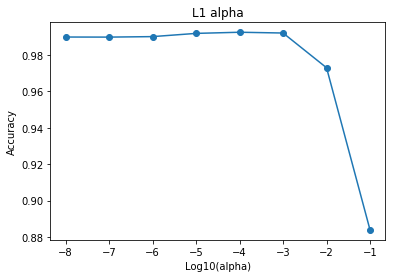

In [13]:
plt.plot(alphas_multiply, L1_accuracy, marker='o')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Accuracy")

Text(0,0.5,'Log-likelihood')

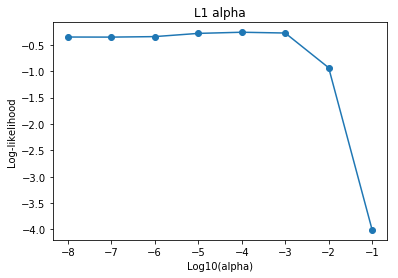

In [14]:
plt.plot(alphas_multiply, L1_log_likelihood, marker='o')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Log-likelihood")

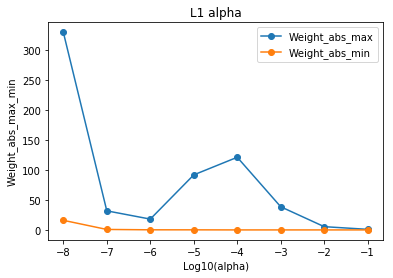

In [15]:
plt.plot(alphas_multiply, L1_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(alphas_multiply, L1_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Weight_abs_max_min")
plt.legend()

## Elastic Net (L1 & L2)
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - **Elastic Net regularization is applied here.**
        - alpha = 1e-4 is fixed.
- Result
    - L2
        - Cross Validation Log-likelihood = -0.345
        - Cross Validation Accuracy = 99.000%
    - L1
        - Cross Validation Log-likelihood = -0.26
        - Cross Validation Accuracy = 99.247%
    - **Elastic Net**
        - **l1_ratio = 0.9 is the best performance here. ( 0.1 <= l1_ratio <= 0.9)**
        - **Cross Validation Log-likelihood = -0.298**
        - **Cross Validation Accuracy = 99.137%**
            - **Only L1 is better performance from the above result.**

In [16]:
penalty = 'elasticnet'

l1_ratios = np.arange(0.1, 1, 0.1)
alpha = 1e-4

EN_accuracy = []
EN_log_likelihood = []
EN_weight_abs_max = []
EN_weight_abs_min = []


for l1_ratio in l1_ratios:
    
    print('='*100)
    print('penalty =', penalty)
    print('alpha =', alpha)
    print('l1_ratio =', l1_ratio)
    print()

    y = df_kick["state_dummy"].values
    X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Cross Validation
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] # Train data
        X_test, y_test = X[test_idx], y[test_idx]     # Test data

    #     print(X_train.shape)
    #     print(X_test.shape)
        df_X_train = pd.DataFrame(X_train,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_test = pd.DataFrame(X_test,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_test = pd.DataFrame(y_test,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

        # Create dummy variables for currency using train data
        # Replace currency to currency_success_rate
        currency_success_rate = {}
        df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
        df_currency_all_count = df_X_train['currency'].value_counts()
        for currency in df_currency_all_count.keys():
            currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
        df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
        df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


    #     display(df_X_train.head())
    #     display(df_y_train.head())

    #     display(df_X_test.head())
    #     display(df_y_test.head())


        print("Fold %s"%split_num)

        X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
        X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

        clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, max_iter=100, fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # Weight
        w0 = clf.intercept_[0]
        w1 = clf.coef_[0, 0]
        w2 = clf.coef_[0, 1]
        w3 = clf.coef_[0, 2]
        w4 = clf.coef_[0, 3]
        w5 = clf.coef_[0, 4]
        w6 = clf.coef_[0, 5]
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


        # Predict labels
        y_est_test = clf.predict(X_test)

        # Log-likelihood
        log_likelihood = - log_loss(y_test, y_est_test)    
        cross_valid_log_likelihood += log_likelihood    
        print('Log-likelihood = {:.3f}'.format(log_likelihood))

        # Accuracy
        accuracy = accuracy_score(y_test, y_est_test)
        cross_valid_accuracy += accuracy   
        print('Accuracy = {:.3f}%'.format(100 * accuracy))
        print()

    #     cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

    # Generalization performance
    final_log_likelihood = cross_valid_log_likelihood / n_split
    print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = cross_valid_accuracy / n_split
    print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    EN_accuracy.append(final_accuracy)
    EN_log_likelihood.append(final_log_likelihood)
    EN_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    EN_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

penalty = elasticnet
alpha = 0.0001
l1_ratio = 0.1

Fold 1
w0 = 1.529, w1 = 1.827, w2 = 10.626, w3 = -11.612, w4 = 1.455, w5 = 1.064, w6 = -0.059
Log-likelihood = -0.461
Accuracy = 98.665%

Fold 2
w0 = 1.600, w1 = 1.852, w2 = 10.659, w3 = -11.630, w4 = 1.391, w5 = 1.038, w6 = -0.037
Log-likelihood = -0.510
Accuracy = 98.522%

Fold 3
w0 = 1.567, w1 = 1.822, w2 = 10.635, w3 = -11.590, w4 = 1.410, w5 = 1.113, w6 = -0.068
Log-likelihood = -0.500
Accuracy = 98.553%

Fold 4
w0 = 1.490, w1 = 1.804, w2 = 10.608, w3 = -11.533, w4 = 1.469, w5 = 1.048, w6 = -0.058
Log-likelihood = -0.495
Accuracy = 98.566%

Fold 5
w0 = 1.552, w1 = 1.840, w2 = 10.668, w3 = -11.632, w4 = 1.391, w5 = 1.048, w6 = -0.052
Log-likelihood = -0.499
Accuracy = 98.554%

Cross Validation Log-likelihood = -0.493
Cross Validation Accuracy = 98.572%
penalty = elasticnet
alpha = 0.0001
l1_ratio = 0.2

Fold 1
w0 = 1.554, w1 = 1.839, w2 = 10.876, w3 = -11.871, w4 = 1.458, w5 = 1.058, w6 = -0.057
Log-likelihood = -0.452
Accuracy = 

Text(0,0.5,'Accuracy')

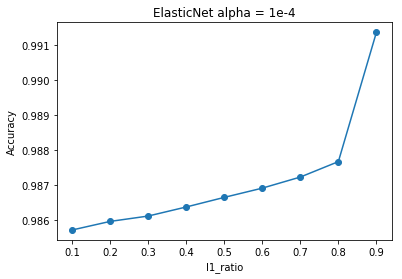

In [17]:
plt.plot(l1_ratios, EN_accuracy, marker='o')
plt.title("ElasticNet alpha = 1e-4")
plt.xlabel("l1_ratio")
plt.ylabel("Accuracy")

Text(0,0.5,'Log-likelihood')

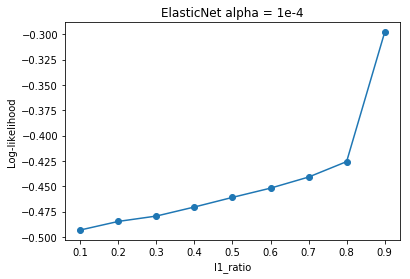

In [18]:
plt.plot(l1_ratios, EN_log_likelihood, marker='o')
plt.title("ElasticNet alpha = 1e-4")
plt.xlabel("l1_ratio")
plt.ylabel("Log-likelihood")

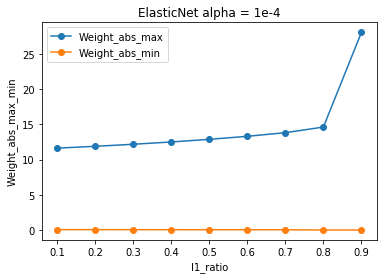

In [19]:
plt.plot(l1_ratios, EN_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(l1_ratios, EN_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("ElasticNet alpha = 1e-4")
plt.xlabel("l1_ratio")
plt.ylabel("Weight_abs_max_min")
plt.legend()

# 3. Apply normalization
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - L1 regularization is applied.
        - alpha = 1e-4 is fixed.
    - **Normalization is applied here.**
- Result
    - Before normalization
        - Cross Validation Log-likelihood = -0.26
        - Cross Validation Accuracy = 99.247%
    - **After normalization**
        - **Cross Validation Log-likelihood = -0.327**
        - **Cross Validation Accuracy = 99.054%**
            - **Normalization didn't contribute to the performance improvement in this case.**

## Check scatter plot before normalization (all data)

In [20]:
df_kick2 = df_kick[["state_dummy", "backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]]
df_kick2.head()

,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category,currency,time_campaign_dummy
0,0,0.000000,0.000000,3.186094,Poetry,GBP,2
1,0,1.204120,3.384174,4.477136,Narrative Film,USD,2
2,0,0.602060,2.344392,4.653222,Narrative Film,USD,1
3,0,0.301030,0.301030,3.699057,Music,USD,1
4,0,1.176091,3.108565,4.290057,Film & Video,USD,1


In [21]:
# Create dummy variables for category using all data
# Replace category to category_success_rate
category_success_rate = {}
df_kick2_category_successful_count = df_kick2['category'][df_kick2['state_dummy'] == 1].value_counts()
df_kick2_category_all_count = df_kick2['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_kick2_category_successful_count[category] / df_kick2_category_all_count[category]
df_kick2['category_dummy'] = df_kick2['category'].replace(category_success_rate)

# Create dummy variables for currency using all data
# Replace currency to currency_success_rate
currency_success_rate = {}
df_kick2_currency_successful_count = df_kick2['currency'][df_kick2['state_dummy'] == 1].value_counts()
df_kick2_currency_all_count = df_kick2['currency'].value_counts()
for currency in df_currency_all_count.keys():
    currency_success_rate[currency] = df_kick2_currency_successful_count[currency] / df_kick2_currency_all_count[currency]
df_kick2['currency_dummy'] = df_kick2['currency'].replace(currency_success_rate) 

df_kick2 = df_kick2[["state_dummy", "backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]]

df_kick2.head()

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
0,0,0.000000,0.000000,3.186094,0.355734,0.353949,2
1,0,1.204120,3.384174,4.477136,0.388011,0.370318,2
2,0,0.602060,2.344392,4.653222,0.388011,0.370318,1
3,0,0.301030,0.301030,3.699057,0.408978,0.370318,1
4,0,1.176091,3.108565,4.290057,0.303720,0.370318,1


In [22]:
df_kick2.describe()

,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
count,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,0.353762,1.139256,2.497927,3.750910,0.353762,0.353762,1.124571
std,0.478137,0.827030,1.440840,0.734568,0.140776,0.040255,0.522084
min,0.000000,0.000000,0.000000,0.004321,0.059574,0.175000,0.000000
25%,0.000000,0.477121,1.505150,3.301247,0.255787,0.370318,1.000000
50%,0.000000,1.113943,2.796109,3.740442,0.348816,0.370318,1.000000
75%,1.000000,1.755875,3.607562,4.190360,0.417582,0.370318,1.000000
max,1.000000,5.341203,7.308329,8.221053,0.771429,0.370318,5.000000


X=backers_log10 Y=usd_pledged_real_log10
Correlation coefficient: 0.920


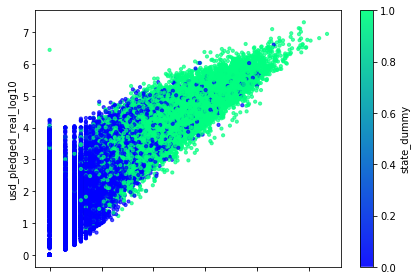

X=backers_log10 Y=usd_goal_real_log10
Correlation coefficient: 0.121


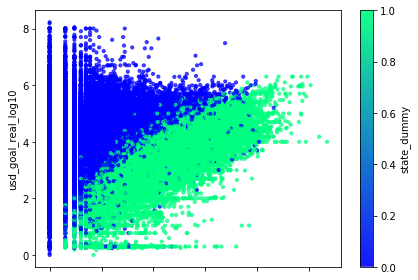

X=backers_log10 Y=category_dummy
Correlation coefficient: 0.249


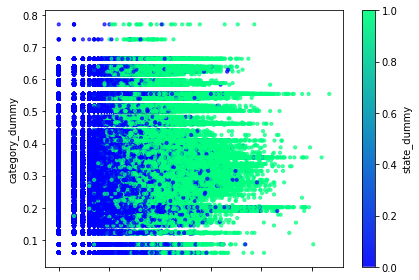

X=backers_log10 Y=currency_dummy
Correlation coefficient: 0.073


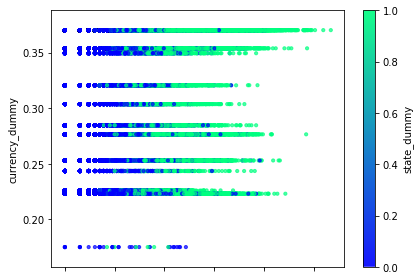

X=backers_log10 Y=time_campaign_dummy
Correlation coefficient: -0.041


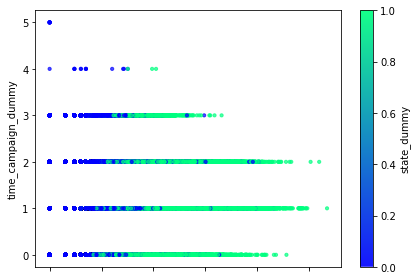

X=usd_pledged_real_log10 Y=usd_goal_real_log10
Correlation coefficient: 0.136


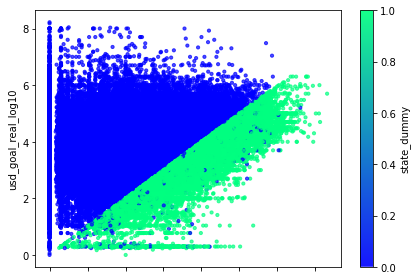

X=usd_pledged_real_log10 Y=category_dummy
Correlation coefficient: 0.253


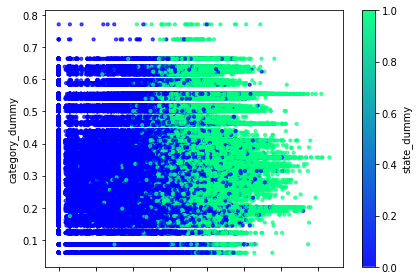

X=usd_pledged_real_log10 Y=currency_dummy
Correlation coefficient: 0.081


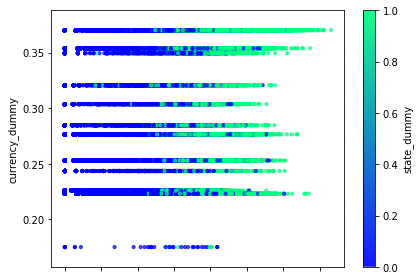

X=usd_pledged_real_log10 Y=time_campaign_dummy
Correlation coefficient: -0.029


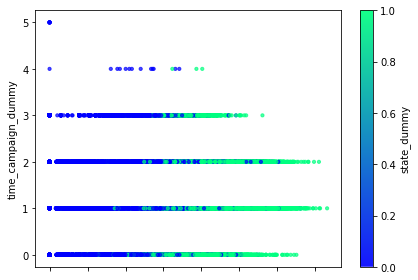

X=usd_goal_real_log10 Y=category_dummy
Correlation coefficient: -0.162


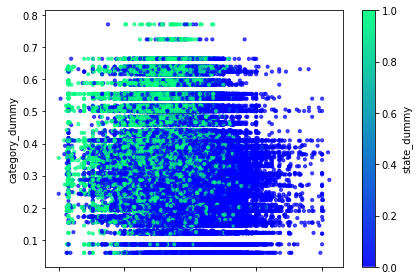

X=usd_goal_real_log10 Y=currency_dummy
Correlation coefficient: -0.026


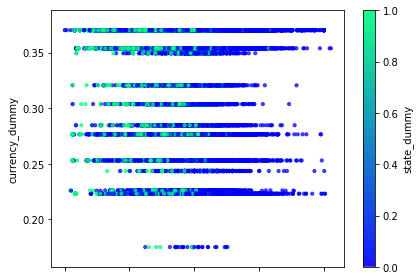

X=usd_goal_real_log10 Y=time_campaign_dummy
Correlation coefficient: 0.145


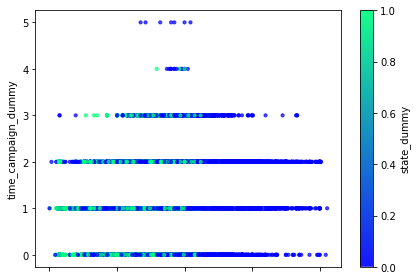

X=category_dummy Y=currency_dummy
Correlation coefficient: 0.115


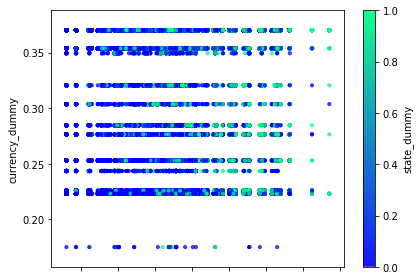

X=category_dummy Y=time_campaign_dummy
Correlation coefficient: -0.012


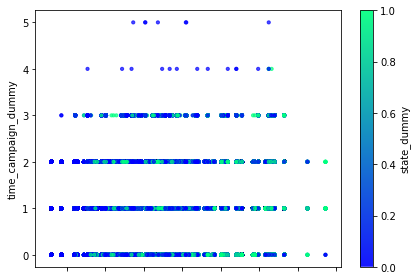

X=currency_dummy Y=time_campaign_dummy
Correlation coefficient: 0.006


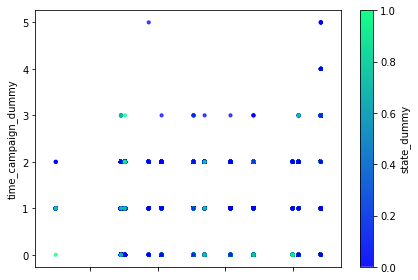

In [23]:
import itertools
li_combi = list(itertools.combinations(df_kick2.columns[1:], 2))
for X,Y in li_combi:
    print("X=%s"%X,"Y=%s"%Y)
    print('Correlation coefficient: {:.3f}'.format(np.corrcoef(df_kick2[X], df_kick2[Y])[0,1]))
    df_kick2.plot(kind="scatter",x=X,y=Y,alpha=0.7,s=10,c="state_dummy",colormap="winter")#散布図の作成
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

## Check scatter plot after normalization (all data)

In [24]:
X_all = df_kick2[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

# Normaliztion
stdsc = StandardScaler()
X_all_stand = stdsc.fit_transform(X_all)
df_X_all_stand = pd.DataFrame(X_all_stand,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"])
df_kick2_stand = pd.concat([df_kick2["state_dummy"], df_X_all_stand], axis=1)
df_kick2_stand.head()

,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
0,0,-1.377529,-1.733663,-0.768909,0.014007,0.004646,1.676800
1,0,0.078430,0.615092,0.988645,0.243284,0.411274,1.676800
2,0,-0.649550,-0.106559,1.228359,0.243284,0.411274,-0.238603
3,0,-1.013540,-1.524736,-0.070590,0.392226,0.411274,-0.238603
4,0,0.044539,0.423808,0.733966,-0.355477,0.411274,-0.238603


In [25]:
df_kick2_stand.describe()

,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
count,378661.000000,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05
mean,0.353762,2.113036e-16,1.656212e-16,5.839360e-16,-3.605058e-16,-3.938955e-15,-2.091879e-16
std,0.478137,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-1.377529e+00,-1.733663e+00,-5.100402e+00,-2.089762e+00,-4.440773e+00,-2.154006e+00
25%,0.000000,-8.006192e-01,-6.890273e-01,-6.121463e-01,-6.959689e-01,4.112740e-01,-2.386028e-01
50%,0.000000,-3.060696e-02,2.069508e-01,-1.425062e-02,-3.513607e-02,4.112740e-01,-2.386028e-01
75%,1.000000,7.455833e-01,7.701322e-01,5.982435e-01,4.533456e-01,4.112740e-01,-2.386028e-01
max,1.000000,5.080776e+00,3.338615e+00,6.085410e+00,2.966890e+00,4.112740e-01,7.423009e+00


X=backers_log10 Y=usd_pledged_real_log10
Correlation coefficient: 0.920


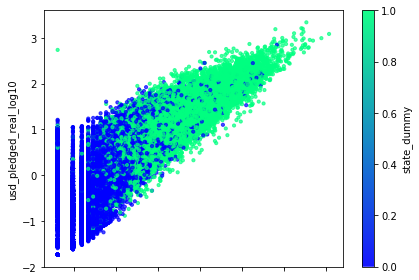

X=backers_log10 Y=usd_goal_real_log10
Correlation coefficient: 0.121


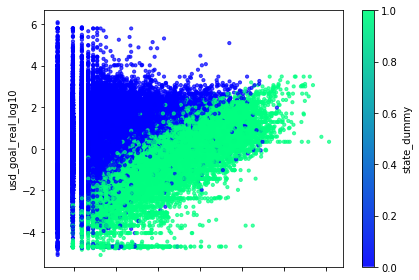

X=backers_log10 Y=category_dummy
Correlation coefficient: 0.249


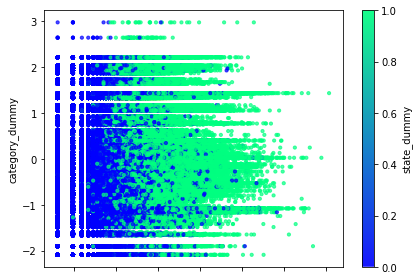

X=backers_log10 Y=currency_dummy
Correlation coefficient: 0.073


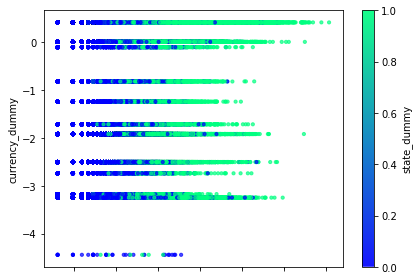

X=backers_log10 Y=time_campaign_dummy
Correlation coefficient: -0.041


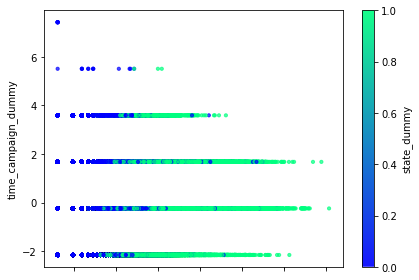

X=usd_pledged_real_log10 Y=usd_goal_real_log10
Correlation coefficient: 0.136


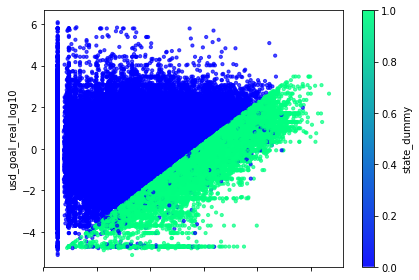

X=usd_pledged_real_log10 Y=category_dummy
Correlation coefficient: 0.253


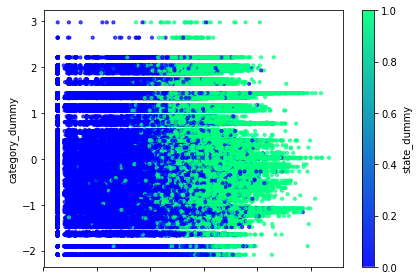

X=usd_pledged_real_log10 Y=currency_dummy
Correlation coefficient: 0.081


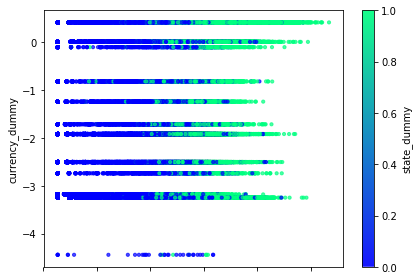

X=usd_pledged_real_log10 Y=time_campaign_dummy
Correlation coefficient: -0.029


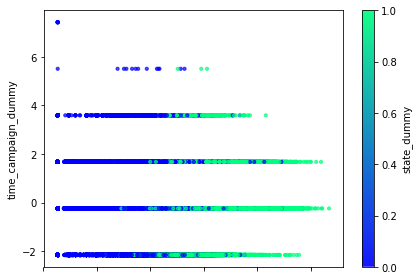

X=usd_goal_real_log10 Y=category_dummy
Correlation coefficient: -0.162


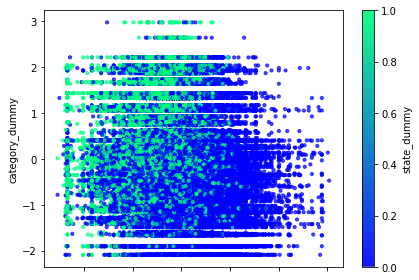

X=usd_goal_real_log10 Y=currency_dummy
Correlation coefficient: -0.026


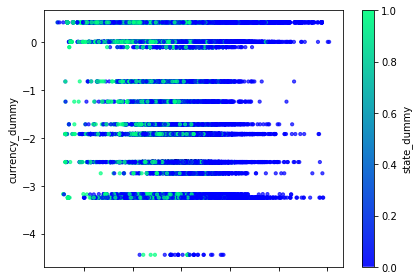

X=usd_goal_real_log10 Y=time_campaign_dummy
Correlation coefficient: 0.145


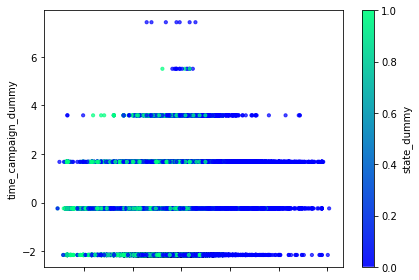

X=category_dummy Y=currency_dummy
Correlation coefficient: 0.115


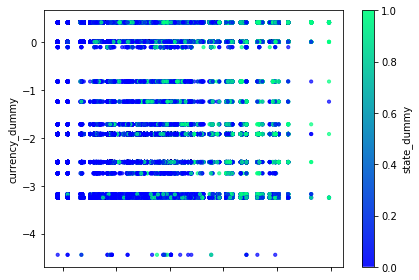

X=category_dummy Y=time_campaign_dummy
Correlation coefficient: -0.012


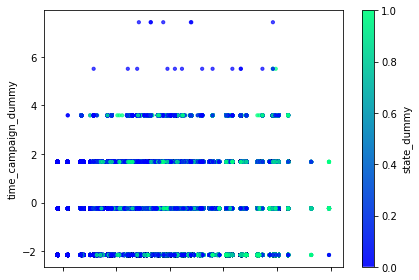

X=currency_dummy Y=time_campaign_dummy
Correlation coefficient: 0.006


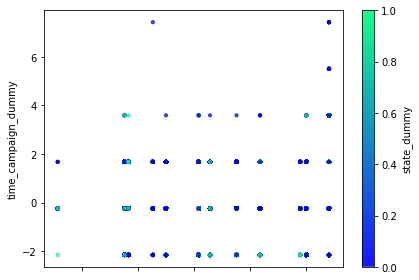

In [26]:
import itertools
li_combi = list(itertools.combinations(df_kick2_stand.columns[1:], 2))
for X,Y in li_combi:
    print("X=%s"%X,"Y=%s"%Y)
    print('Correlation coefficient: {:.3f}'.format(np.corrcoef(df_kick2_stand[X], df_kick2_stand[Y])[0,1]))
    df_kick2_stand.plot(kind="scatter",x=X,y=Y,alpha=0.7,s=10,c="state_dummy",colormap="winter")#散布図の作成
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

## L1 alpha=1e-4, normalization

In [27]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
    w3 = clf.coef_[0, 2]
    w4 = clf.coef_[0, 3]
    w5 = clf.coef_[0, 4]
    w6 = clf.coef_[0, 5]
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -26.168, w1 = 1.940, w2 = 31.016, w3 = -16.718, w4 = 0.250, w5 = 0.197, w6 = -0.028
Log-likelihood = -0.312
Accuracy = 99.096%

Fold 2
w0 = -27.103, w1 = 1.982, w2 = 32.140, w3 = -17.297, w4 = 0.230, w5 = 0.181, w6 = -0.013
Log-likelihood = -0.326
Accuracy = 99.057%

Fold 3
w0 = -25.514, w1 = 1.902, w2 = 30.367, w3 = -16.383, w4 = 0.233, w5 = 0.195, w6 = -0.037
Log-likelihood = -0.326
Accuracy = 99.057%

Fold 4
w0 = -23.532, w1 = 1.832, w2 = 28.099, w3 = -15.174, w4 = 0.250, w5 = 0.179, w6 = -0.032
Log-likelihood = -0.333
Accuracy = 99.036%

Fold 5
w0 = -24.348, w1 = 1.897, w2 = 29.033, w3 = -15.668, w4 = 0.232, w5 = 0.186, w6 = -0.024
Log-likelihood = -0.337
Accuracy = 99.023%

Cross Validation Log-likelihood = -0.327
Cross Validation Accuracy = 99.054%


# 4. Apply decorrelation
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - L1 regularization is applied.
        - alpha = 1e-4 is fixed.
    - Normalization is applied.
    - **Decorrelation is applied here.**
- Result
    - Before normalization
        - Cross Validation Log-likelihood = -0.26
        - Cross Validation Accuracy = 99.247%
    - After normalization
        - Cross Validation Log-likelihood = -0.327
        - Cross Validation Accuracy = 99.054%
            - Normalization didn't contribute to the performance improvement in this case.
    - **After normalization and decorrelation**
        - **Cross Validation Log-likelihood = -0.329**
        - **Cross Validation Accuracy = 99.048%**
            - **Decorrelation didn't contribute to the performance improvement in this case.**

## Check scatter plot after normalization and decorrelation (all data)

In [28]:
X_all = df_kick2[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values


# Normaliztion
stdsc = StandardScaler()
X_all_stand = stdsc.fit_transform(X_all)

# Decorrelation
cov = np.cov(X_all_stand, rowvar=0) # Estimate the covariance matrix
print('cov =', cov)
_, S = np.linalg.eig(cov)           # Compute the eigenvalues and right eigenvectors of the covariance matrix
print('_ =', _)
print('S =', S)
X_all_stand_decorr = np.dot(S.T, X_all_stand.T).T # Decorrelate the data

df_X_all_stand = pd.DataFrame(X_all_stand_decorr,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"])
df_kick2_stand_decorr = pd.concat([df_kick2["state_dummy"], df_X_all_stand], axis=1)
df_kick2_stand_decorr.head()

cov = [[ 1.00000264  0.91956015  0.12062848  0.24854887  0.07323636 -0.04121504]
 [ 0.91956015  1.00000264  0.13593714  0.25268916  0.08067192 -0.02904659]
 [ 0.12062848  0.13593714  1.00000264 -0.16153759 -0.02622439  0.14510902]
 [ 0.24854887  0.25268916 -0.16153759  1.00000264  0.11456521 -0.01180867]
 [ 0.07323636  0.08067192 -0.02622439  0.11456521  1.00000264  0.00551737]
 [-0.04121504 -0.02904659  0.14510902 -0.01180867  0.00551737  1.00000264]]
_ = [2.07244988 0.08020079 0.6822285  1.23195786 1.02315407 0.91002475]
S = [[ 0.66160753  0.7052896  -0.20752569  0.07848189  0.12492915 -0.00290543]
 [ 0.66332421 -0.70873084 -0.19426595  0.0894917   0.10926522 -0.00383137]
 [ 0.10478318  0.01224574  0.62660675  0.7193425  -0.04151972 -0.27759141]
 [ 0.3075694   0.00566698  0.65332816 -0.4619583  -0.27523603  0.43516769]
 [ 0.12520702  0.00560262 -0.0813868  -0.24306197 -0.69261689 -0.66247318]
 [-0.03195651  0.00732915 -0.30511689  0.44259869 -0.6444043   0.54284274]]


,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
0,0,-2.190628,0.260122,-0.361987,-0.081819,-1.417208,1.137343
1,0,0.636225,-0.352540,0.097576,1.302173,-1.396395,0.466626
2,0,-0.237773,-0.365623,1.123471,0.505140,-0.341851,-0.634799
3,0,-1.509600,0.367702,0.757889,-0.653536,-0.529344,-0.202916
4,0,0.337282,-0.261424,0.175420,0.528041,-0.011861,-0.762170


In [29]:
df_kick2_stand_decorr.describe()

,state_dummy,backers_log10,usd_pledged_real_log10,usd_goal_real_log10,category_dummy,currency_dummy,time_campaign_dummy
count,378661.000000,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05,3.786610e+05
mean,0.353762,-2.616350e-16,6.806864e-18,4.489246e-16,1.474561e-15,2.973591e-15,2.174124e-15
std,0.478137,1.439601e+00,2.831974e-01,8.259712e-01,1.109936e+00,1.011511e+00,9.539522e-01
min,0.000000,-3.447658e+00,-2.871814e+00,-4.819974e+00,-5.487890e+00,-5.950138e+00,-3.392082e+00
25%,0.000000,-1.141436e+00,-1.714719e-01,-5.484317e-01,-7.349850e-01,-4.556507e-01,-6.541594e-01
50%,0.000000,9.364125e-02,3.296562e-03,-6.576027e-03,-7.507542e-03,-6.998630e-02,-1.563474e-01
75%,1.000000,1.126000e+00,2.338720e-01,5.475163e-01,7.264359e-01,3.003692e-01,5.133286e-01
max,1.000000,5.941886e+00,1.409433e+00,5.145394e+00,6.084320e+00,4.558159e+00,5.781606e+00


X=backers_log10 Y=usd_pledged_real_log10
Correlation coefficient: 0.000


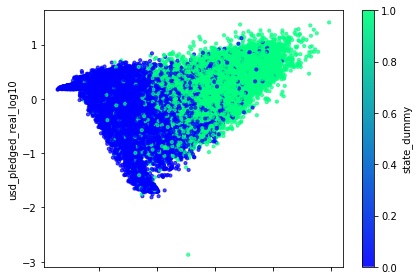

X=backers_log10 Y=usd_goal_real_log10
Correlation coefficient: 0.000


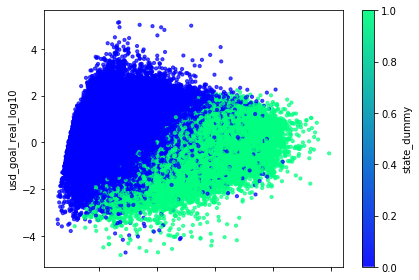

X=backers_log10 Y=category_dummy
Correlation coefficient: -0.000


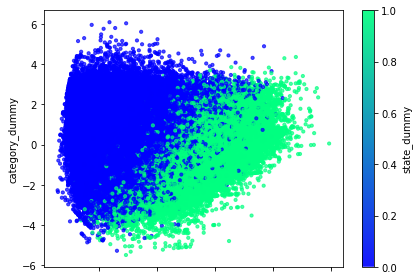

X=backers_log10 Y=currency_dummy
Correlation coefficient: -0.000


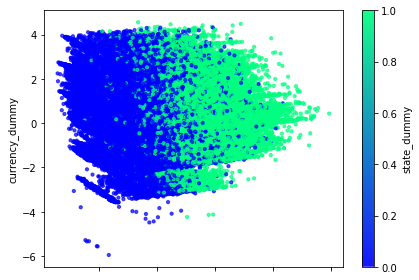

X=backers_log10 Y=time_campaign_dummy
Correlation coefficient: 0.000


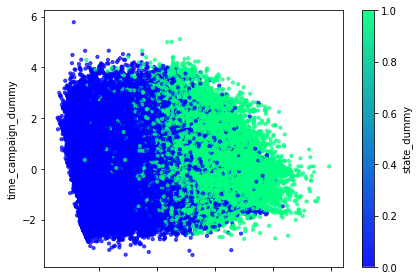

X=usd_pledged_real_log10 Y=usd_goal_real_log10
Correlation coefficient: -0.000


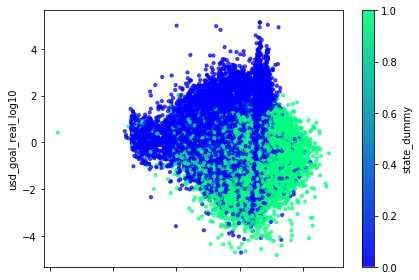

X=usd_pledged_real_log10 Y=category_dummy
Correlation coefficient: 0.000


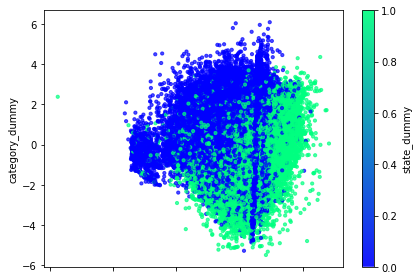

X=usd_pledged_real_log10 Y=currency_dummy
Correlation coefficient: 0.000


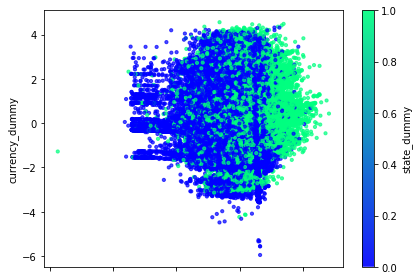

X=usd_pledged_real_log10 Y=time_campaign_dummy
Correlation coefficient: 0.000


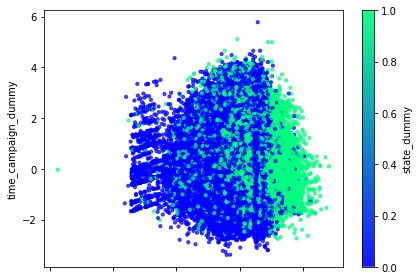

X=usd_goal_real_log10 Y=category_dummy
Correlation coefficient: -0.000


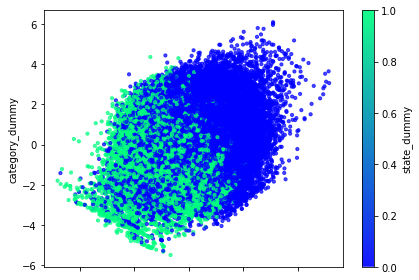

X=usd_goal_real_log10 Y=currency_dummy
Correlation coefficient: -0.000


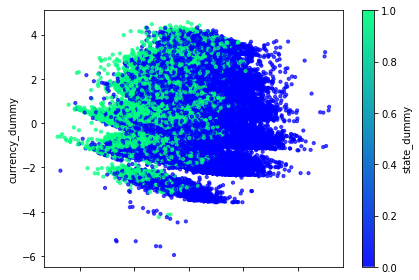

X=usd_goal_real_log10 Y=time_campaign_dummy
Correlation coefficient: -0.000


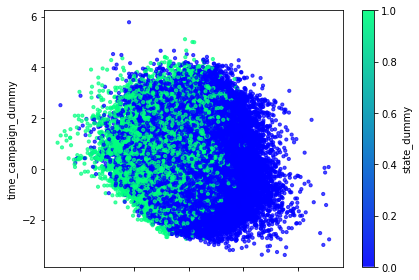

X=category_dummy Y=currency_dummy
Correlation coefficient: 0.000


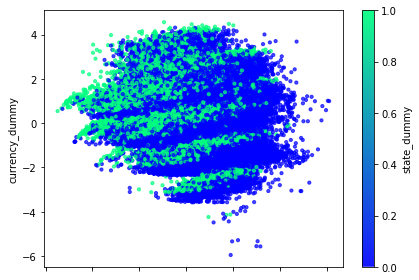

X=category_dummy Y=time_campaign_dummy
Correlation coefficient: -0.000


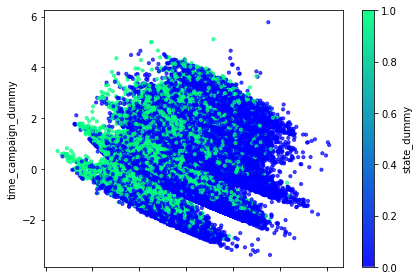

X=currency_dummy Y=time_campaign_dummy
Correlation coefficient: -0.000


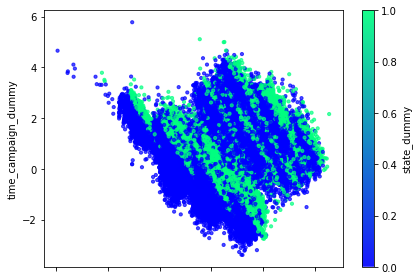

In [30]:
import itertools
li_combi = list(itertools.combinations(df_kick2_stand_decorr.columns[1:], 2))
for X,Y in li_combi:
    print("X=%s"%X,"Y=%s"%Y)
    print('Correlation coefficient: {:.3f}'.format(np.corrcoef(df_kick2_stand_decorr[X], df_kick2_stand_decorr[Y])[0,1]))
    df_kick2_stand_decorr.plot(kind="scatter",x=X,y=Y,alpha=0.7,s=10,c="state_dummy",colormap="winter")#散布図の作成
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.tight_layout()
    plt.show()

## L1 alpha=1e-4, normalization and decorrelation

In [31]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    # Decorrelation
    cov = np.cov(X_train_stand, rowvar=0) # Estimate the covariance matrix
#     print('cov =', cov)
    _, S = np.linalg.eig(cov)           # Compute the eigenvalues and right eigenvectors of the covariance matrix
#     print('_ =', _)
#     print('S =', S)
    X_train_stand_decorr = np.dot(S.T, X_train_stand.T).T # Decorrelate train data
    X_test_stand_decorr = np.dot(S.T, X_test_stand.T).T # Decorrelate train data
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand_decorr, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
    w3 = clf.coef_[0, 2]
    w4 = clf.coef_[0, 3]
    w5 = clf.coef_[0, 4]
    w6 = clf.coef_[0, 5]
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand_decorr)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -24.800, w1 = 19.240, w2 = -19.710, w3 = -15.925, w4 = -8.797, w5 = 3.958, w6 = 4.257
Log-likelihood = -0.322
Accuracy = 99.069%

Fold 2
w0 = -26.316, w1 = 20.370, w2 = -20.933, w3 = -16.879, w4 = -9.343, w5 = 4.117, w6 = 4.471
Log-likelihood = -0.332
Accuracy = 99.040%

Fold 3
w0 = -25.128, w1 = 19.503, w2 = -20.052, w3 = -16.164, w4 = -8.989, w5 = 4.006, w6 = 4.313
Log-likelihood = -0.328
Accuracy = 99.049%

Fold 4
w0 = -25.118, w1 = 19.515, w2 = -20.036, w3 = -16.110, w4 = -8.953, w5 = 4.056, w6 = 4.329
Log-likelihood = -0.322
Accuracy = 99.068%

Fold 5
w0 = -24.135, w1 = -18.798, w2 = 19.232, w3 = 15.620, w4 = -8.632, w5 = 3.766, w6 = 4.148
Log-likelihood = -0.341
Accuracy = 99.014%

Cross Validation Log-likelihood = -0.329
Cross Validation Accuracy = 99.048%


# 5. Apply SVM
- Model
    - The same model as Day 1
        - **But SVM is applied here instead of linear regression**
    - Normalization is applied.
    - Decorrelation is applied.
    - **Holdout method is applied for SVM instead of cross validation to shorten the calculation time.**
- Result
    - Linear Regression
        - Before normalization and decorrelation
            - Cross Validation Log-likelihood = -0.26
            - Cross Validation Accuracy = 99.247%
        - After normalization and decorrelation
            - Cross Validation Log-likelihood = -0.329
            - Cross Validation Accuracy = 99.048%
    - **SVM**
        - **kernel = linear**
            - **C = 10 is the best performance here. (0.001 <= C <= 10)**
            - **Holdout Log-likelihood = -0.41**
            - **Holdout Accuracy = 98.813%**
        - **kernel = rbf**
            - **(C = 10, gamma = 1) is the best performance here. (0.001 <= C <= 10) (0.01 <= gamma <= 100)**
            - **Holdout Log-likelihood = -0.248**
            - **Holdout Accuracy = 99.282%**
            - **Cross Validation Log-likelihood = -0.245**
            - **<font color='red'>Cross Validation Accuracy = 99.290% (Best accuracy in this notebook)</font>**

## SVM kernel=linear

In [32]:
kernel = 'linear'
Cs = [0.001, 0.01, 0.1, 1, 10]

SVM_accuracy = []
SVM_log_likelihood = []
SVM_weight_abs_max = []
SVM_weight_abs_min = []


for C in Cs:
    
    print('='*100)
    print('kernel =', kernel)
    print('C =', C)
    print()
    

    y = df_kick["state_dummy"].values
    X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Holdout method
        

        
    test_size = 0.2        # 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)

    # Decorrelation
    cov = np.cov(X_train_stand, rowvar=0) # Estimate the covariance matrix
#     print('cov =', cov)
    _, S = np.linalg.eig(cov)           # Compute the eigenvalues and right eigenvectors of the covariance matrix
#     print('_ =', _)
#     print('S =', S)
    X_train_stand_decorr = np.dot(S.T, X_train_stand.T).T # Decorrelate train data
    X_test_stand_decorr = np.dot(S.T, X_test_stand.T).T # Decorrelate train data



#     clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf = SVC(C=C,kernel=kernel)
    clf.fit(X_train_stand_decorr, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
    w3 = clf.coef_[0, 2]
    w4 = clf.coef_[0, 3]
    w5 = clf.coef_[0, 4]
    w6 = clf.coef_[0, 5]
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand_decorr)

    # Log-likelihood
    holdout_log_likelihood = - log_loss(y_test, y_est_test)       

    # Accuracy
    holdout_accuracy = accuracy_score(y_test, y_est_test)  



    # Generalization performance
    final_log_likelihood = holdout_log_likelihood
    print("Holdout Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = holdout_accuracy
    print('Holdout Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    SVM_accuracy.append(final_accuracy)
    SVM_log_likelihood.append(final_log_likelihood)
    SVM_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    SVM_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

kernel = linear
C = 0.001

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -3.192, w1 = -2.917, w2 = 2.514, w3 = 2.434, w4 = -1.376, w5 = 0.594, w6 = 0.656
Holdout Log-likelihood = -0.857
Holdout Accuracy = 97.519%
kernel = linear
C = 0.01

Fold 1
w0 = -6.223, w1 = -5.060, w2 = 5.688, w3 = 4.267, w4 = -2.323, w5 = 1.066, w6 = 1.137
Holdout Log-likelihood = -0.559
Holdout Accuracy = 98.382%
kernel = linear
C = 0.1

Fold 1
w0 = -9.409, w1 = -7.313, w2 = 8.311, w3 = 6.174, w4 = -3.352, w5 = 1.548, w6 = 1.643
Holdout Log-likelihood = -0.434
Holdout Accuracy = 98.743%
kernel = linear
C = 1

Fold 1
w0 = -10.698, w1 = -8.227, w2 = 9.339, w3 = 6.947, w4 = -3.770, w5 = 1.743, w6 = 1.848
Holdout Log-likelihood = -0.413
Holdout Accuracy = 98.805%
kernel = linear
C = 10

Fold 1
w0 = -10.884, w1 = -8.359, w2 = 9.480, w3 = 7.059, w4 = -3.831, w5 = 1.771, w6 = 1.877
Holdout Log-likelihood = -0.41
Holdout Accuracy = 98.813%


Text(0,0.5,'Accuracy')

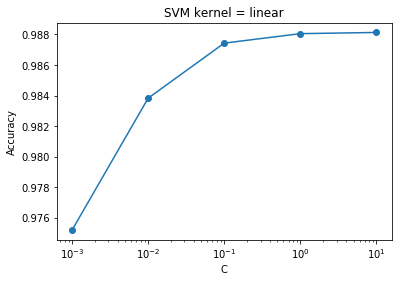

In [33]:
plt.plot(Cs, SVM_accuracy, marker='o')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")

Text(0,0.5,'Log-likelihood')

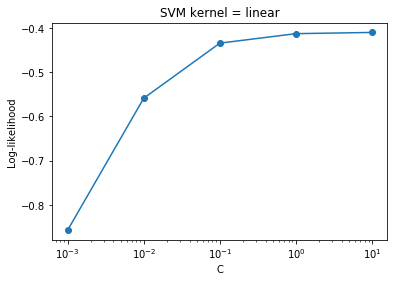

In [34]:
plt.plot(Cs, SVM_log_likelihood, marker='o')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Log-likelihood")

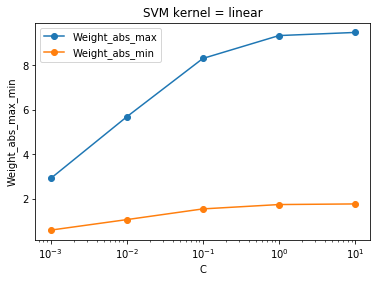

In [35]:
plt.plot(Cs, SVM_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(Cs, SVM_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Weight_abs_max_min")
plt.legend()

## SVM kernel=rbf

In [36]:
kernel = 'rbf'
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.01, 0.1, 1, 10, 100]

SVM_accuracy = []
SVM_log_likelihood = []
SVM_weight_abs_max = []
SVM_weight_abs_min = []


for C in Cs:
    for gamma in gammas:
    
        print('='*100)
        print('kernel =', kernel)
        print('C =', C)
        print('gamma =', gamma)
        print()


        y = df_kick["state_dummy"].values
        X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

        n_split = 5 # Number of group

        cross_valid_log_likelihood = 0
        cross_valid_accuracy = 0
        split_num = 1

        # Holdout method



        test_size = 0.2        # 20%
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

    #     print(X_train.shape)
    #     print(X_test.shape)
        df_X_train = pd.DataFrame(X_train,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_test = pd.DataFrame(X_test,
                                 columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
        df_y_test = pd.DataFrame(y_test,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

        # Create dummy variables for currency using train data
        # Replace currency to currency_success_rate
        currency_success_rate = {}
        df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
        df_currency_all_count = df_X_train['currency'].value_counts()
        for currency in df_currency_all_count.keys():
            currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
        df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
        df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


    #     display(df_X_train.head())
    #     display(df_y_train.head())

    #     display(df_X_test.head())
    #     display(df_y_test.head())


        print("Fold %s"%split_num)

        X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
        X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

        # Normaliztion
        stdsc = StandardScaler()
        X_train_stand = stdsc.fit_transform(X_train)
        X_test_stand = stdsc.transform(X_test)

        # Decorrelation
        cov = np.cov(X_train_stand, rowvar=0) # Estimate the covariance matrix
    #     print('cov =', cov)
        _, S = np.linalg.eig(cov)           # Compute the eigenvalues and right eigenvectors of the covariance matrix
    #     print('_ =', _)
    #     print('S =', S)
        X_train_stand_decorr = np.dot(S.T, X_train_stand.T).T # Decorrelate train data
        X_test_stand_decorr = np.dot(S.T, X_test_stand.T).T # Decorrelate train data



    #     clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
#         clf = SVC(C=C, kernel=kernel)
        clf = SVC(C=C, kernel=kernel, gamma=gamma)
        clf.fit(X_train_stand_decorr, y_train)

#         # Weight
#         w0 = clf.intercept_[0]
#         w1 = clf.coef_[0, 0]
#         w2 = clf.coef_[0, 1]
#         w3 = clf.coef_[0, 2]
#         w4 = clf.coef_[0, 3]
#         w5 = clf.coef_[0, 4]
#         w6 = clf.coef_[0, 5]
#         print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

    #         plt.plot(np.abs(clf.coef_.T), marker='o')


        # Predict labels
        y_est_test = clf.predict(X_test_stand_decorr)

        # Log-likelihood
        holdout_log_likelihood = - log_loss(y_test, y_est_test)       

        # Accuracy
        holdout_accuracy = accuracy_score(y_test, y_est_test)  



        # Generalization performance
        final_log_likelihood = holdout_log_likelihood
        print("Holdout Log-likelihood = %s"%round(final_log_likelihood, 3))
        final_accuracy = holdout_accuracy
        print('Holdout Accuracy = {:.3f}%'.format(100 * final_accuracy))

        SVM_accuracy.append(final_accuracy)
        SVM_log_likelihood.append(final_log_likelihood)
#         SVM_weight_abs_max.append(np.max(np.abs(clf.coef_)))
#         SVM_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

kernel = rbf
C = 0.001
gamma = 0.01

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Holdout Log-likelihood = -2.554
Holdout Accuracy = 92.606%
kernel = rbf
C = 0.001
gamma = 0.1

Fold 1
Holdout Log-likelihood = -1.721
Holdout Accuracy = 95.017%
kernel = rbf
C = 0.001
gamma = 1

Fold 1
Holdout Log-likelihood = -3.067
Holdout Accuracy = 91.119%
kernel = rbf
C = 0.001
gamma = 10

Fold 1
Holdout Log-likelihood = -9.993
Holdout Accuracy = 71.068%
kernel = rbf
C = 0.001
gamma = 100

Fold 1
Holdout Log-likelihood = -12.154
Holdout Accuracy = 64.811%
kernel = rbf
C = 0.01
gamma = 0.01

Fold 1
Holdout Log-likelihood = -1.435
Holdout Accuracy = 95.845%
kernel = rbf
C = 0.01
gamma = 0.1

Fold 1
Holdout Log-likelihood = -0.835
Holdout Accuracy = 97.584%
kernel = rbf
C = 0.01
gamma = 1

Fold 1
Holdout Log-likelihood = -1.072
Holdout Accuracy = 96.897%
kernel = rbf
C = 0.01
gamma = 10

Fold 1
Holdout Log-likelihood = -4.011
Holdout Accuracy = 88.387%
kernel = rbf
C = 0.01
gamma = 100

Fold 1
Holdout Log-likelihood = -11.783
Holdout Accuracy = 65.884%
kernel = rbf
C = 0.1
gamma = 0.

In [39]:
SVM_accuracy_2d = np.array(SVM_accuracy).reshape(5, 5)
SVM_accuracy_2d

array([[0.92605601, 0.95016703, 0.91118799, 0.71068094, 0.64810585],
       [0.95844612, 0.97583616, 0.96896993, 0.88386833, 0.65884093],
       [0.98003512, 0.98715223, 0.98585821, 0.96013627, 0.81013561],
       [0.98896122, 0.99129838, 0.99111352, 0.98527722, 0.93136413],
       [0.99154926, 0.99264521, 0.99281687, 0.98622793, 0.93630254]])

In [41]:
Cs_str = list(map(str, Cs))
Cs_str

['0.001', '0.01', '0.1', '1', '10']

In [42]:
gammas_str = list(map(str, gammas))
gammas_str

['0.01', '0.1', '1', '10', '100']

In [43]:
df_SVM_accuracy_2d = pd.DataFrame(data=SVM_accuracy_2d, index=Cs_str, columns=gammas_str)
df_SVM_accuracy_2d

,0.01,0.1,1,10,100
0.001,0.926056,0.950167,0.911188,0.710681,0.648106
0.01,0.958446,0.975836,0.968970,0.883868,0.658841
0.1,0.980035,0.987152,0.985858,0.960136,0.810136
1,0.988961,0.991298,0.991114,0.985277,0.931364
10,0.991549,0.992645,0.992817,0.986228,0.936303


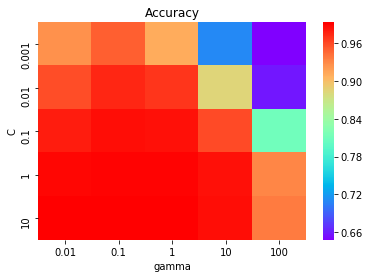

In [46]:
sns.heatmap(df_SVM_accuracy_2d, cmap='rainbow')
plt.ylabel("C")
plt.xlabel("gamma")
plt.title('Accuracy')
plt.show()

In [49]:
np.max(SVM_accuracy_2d)

0.9928168697925607

## SVM kernel=rbf (C=10, gamma=1) Cross-Validation / Final Check

In [50]:
kernel = 'rbf'
C = 10
gamma = 1

y = df_kick["state_dummy"].values
X = df_kick[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    # Decorrelation
    cov = np.cov(X_train_stand, rowvar=0) # Estimate the covariance matrix
#     print('cov =', cov)
    _, S = np.linalg.eig(cov)           # Compute the eigenvalues and right eigenvectors of the covariance matrix
#     print('_ =', _)
#     print('S =', S)
    X_train_stand_decorr = np.dot(S.T, X_train_stand.T).T # Decorrelate train data
    X_test_stand_decorr = np.dot(S.T, X_test_stand.T).T # Decorrelate train data
    
    
    
#     clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_train_stand_decorr, y_train)

    # Weight
#     w0 = clf.intercept_[0]
#     w1 = clf.coef_[0, 0]
#     w2 = clf.coef_[0, 1]
#     w3 = clf.coef_[0, 2]
#     w4 = clf.coef_[0, 3]
#     w5 = clf.coef_[0, 4]
#     w6 = clf.coef_[0, 5]
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand_decorr)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Log-likelihood = -0.245
Accuracy = 99.291%

Fold 2
Log-likelihood = -0.245
Accuracy = 99.291%

Fold 3
Log-likelihood = -0.242
Accuracy = 99.300%

Fold 4
Log-likelihood = -0.247
Accuracy = 99.286%

Fold 5
Log-likelihood = -0.247
Accuracy = 99.284%

Cross Validation Log-likelihood = -0.245
Cross Validation Accuracy = 99.290%


# Summary
- When logistic regression was applied, regularization, normalization and decorrelation didn't contribute to improving the generalization performance in this case.
- SVM using RBF kernel showed slightly higher performance than logistic regression.